# RAGdoll Key Modules Demo

Hands-on walkthrough for ingestion, chunking, embeddings, storage layers, and orchestration. Every example relies on the sample assets under `tests/test_data`, so the notebook can run offline.

> **Note:** 
- Set `USE_OPENAI = True` at the top to use real OpenAI embeddings, `False` for fake embeddings.
- Cells 7 and 9 call OpenAI's GPT endpoints via `get_llm_caller`. Export `OPENAI_API_KEY` (or add it to `.env`) before running them.


## What you'll see

1. **Ingestion** ? `DocumentLoaderService` from [`docs/ingestion.md`](../docs/ingestion.md).
2. **Chunking** ? `ragdoll.chunkers` helpers from [`docs/chunking.md`](../docs/chunking.md).
3. **Embeddings** ? provider factory from [`docs/embeddings.md`](../docs/embeddings.md) controlled by USE_OPENAI flag.
4. **Vector stores** ? `vector_store_from_config` customization from [`docs/vector_stores.md`](../docs/vector_stores.md).
5. **Graph stores** ? `get_graph_store` JSON persistence from [`docs/graph_stores.md`](../docs/graph_stores.md).
6. **Graph retrievers** ? `GraphPersistenceService` simple/Neo4j backends from [`docs/graph_stores.md`](../docs/graph_stores.md).
7. **LLMs** ? `get_llm_caller`/`call_llm_sync` bridge described in [`docs/llm_integration.md`](../docs/llm_integration.md) hitting your real OpenAI model.
8. **Pipeline** ? `IngestionPipeline` snapshot from [`docs/architecture.md`](../docs/architecture.md).
9. **Ragdoll** ? orchestrator entry point tying everything together.

Each cell builds on the previous ones so you can treat this as a scratchpad for experimenting with new loaders or configuration overrides.


In [1]:
from pathlib import Path
from pprint import pprint
import shutil
import time

from langchain_core.documents import Document

from ragdoll import Ragdoll
from ragdoll.app_config import bootstrap_app
from ragdoll.ingestion import DocumentLoaderService
from ragdoll.chunkers import get_text_splitter, split_documents
from ragdoll.embeddings import get_embedding_model
from ragdoll.vector_stores import vector_store_from_config
from ragdoll.config.base_config import VectorStoreConfig
from ragdoll.graph_stores import get_graph_store
from ragdoll.entity_extraction import EntityExtractionService
from ragdoll.entity_extraction.models import Graph, GraphNode, GraphEdge
from ragdoll.entity_extraction.graph_persistence import GraphPersistenceService
from ragdoll.llms import get_llm_caller
from ragdoll.llms.callers import call_llm_sync
from ragdoll.pipeline import ingest_documents, IngestionPipeline, IngestionOptions
from dotenv import load_dotenv

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
load_dotenv(override=True)

DATA_DIR = Path('../tests/test_data').resolve()
STATE_DIR = Path('demo_state').resolve()
STATE_DIR.mkdir(exist_ok=True)

SAMPLE_TXT = DATA_DIR / 'test_txt.txt'
#SAMPLE_TXT = DATA_DIR / '*'

# Set to True to use real OpenAI embeddings, False for fake embeddings
USE_OPENAI = True

app_config = bootstrap_app(
    overrides={
        'monitor': {'enabled': False, 'collect_metrics': False},
    }
)


def normalize_documents(raw_docs):
    docs = []
    for entry in raw_docs:
        if isinstance(entry, Document):
            docs.append(entry)
        elif isinstance(entry, dict):
            docs.append(
                Document(
                    page_content=str(entry.get('page_content', '')),
                    metadata=entry.get('metadata', {}) or {},
                )
            )
        else:
            docs.append(Document(page_content=str(entry), metadata={}))
    return docs


def reset_subdir(name: str) -> Path:
    path = STATE_DIR / name
    if path.exists():
        for attempt in range(5):
            try:
                shutil.rmtree(path)
                break
            except PermissionError:
                time.sleep(0.5)
        else:
            timestamped = STATE_DIR / f"{name}_{int(time.time())}"
            timestamped.mkdir(parents=True, exist_ok=True)
            print(f"Warning: {path} was locked, using {timestamped} instead.")
            return timestamped
    path.mkdir(parents=True, exist_ok=True)
    return path

In [3]:
import os
k = os.getenv("OPENAI_API_KEY")
print("Key len:", len(k), "prefix:", k[:12], "suffix:", k[-6:])

Key len: 164 prefix: sk-proj-mmF6 suffix: Df1oEA


## 1. Load sample data
`DocumentLoaderService` fans out across the loader registry defined in `ragdoll/config/default_config.yaml`. We point it at the lightweight TXT fixture so the demo does not need optional dependencies.


In [4]:
loader = DocumentLoaderService(
    app_config=app_config,
    use_cache=False,
    collect_metrics=False,
)

raw_documents = loader.ingest_documents([str(SAMPLE_TXT)])
documents = normalize_documents(raw_documents)

print(f"Loaded {len(documents)} document(s) from {SAMPLE_TXT.name}")
print('Metadata sample:')
pprint(documents[0].metadata)
print('Preview:')
print(documents[0].page_content[:400])


Loaded 1 document(s) from test_txt.txt
Metadata sample:
{'source': 'C:\\dev\\RAGdoll\\tests\\test_data\\test_txt.txt'}
Preview:
Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved information into a dynamic knowledge graph rather than treating it as flat text chunks. At its core, it begins with a user query that triggers a retrieval step from a vector database or search index. Instead of directly feeding retrieved documents into a


## 2. Chunk documents
`ragdoll.chunkers.get_text_splitter` mirrors the strategies in [`docs/chunking.md`](../docs/chunking.md). Reusing the splitter instance keeps experiments consistent when you tweak chunk sizes/overlap.


In [5]:
splitter = get_text_splitter(
    splitter_type='recursive',
    chunk_size=250,
    chunk_overlap=40,
    app_config=app_config,
)
chunks = split_documents(documents, text_splitter=splitter)

print(f"Created {len(chunks)} chunk(s)")
for idx, chunk in enumerate(chunks[:3], start=1):
    preview = chunk.page_content[:180].replace('\n', ' ')
    print(f"Chunk {idx} metadata: {chunk.metadata}")
    print(preview)
    print('---')


Created 20 chunk(s)
Chunk 1 metadata: {'source': 'C:\\dev\\RAGdoll\\tests\\test_data\\test_txt.txt'}
Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved information into a dynamic knowled
---
Chunk 2 metadata: {'source': 'C:\\dev\\RAGdoll\\tests\\test_data\\test_txt.txt'}
it as flat text chunks. At its core, it begins with a user query that triggers a retrieval step from a vector database or search index. Instead of directly feeding retrieved docume
---
Chunk 3 metadata: {'source': 'C:\\dev\\RAGdoll\\tests\\test_data\\test_txt.txt'}
the system parses these documents to extract entities (such as people, organizations, or concepts) and relationships (like "works at" or "caused by") using named entity recognition
---


## 3. Create embeddings
`ragdoll.embeddings.get_embedding_model` instantiates providers dynamically. Passing `provider="fake"` gives deterministic vectors without hitting OpenAI/HuggingFace, but the rest of the flow matches production usage.


In [6]:
#print(os.getenv("OPENAI_API_KEY"))

In [7]:
embedding_inputs = [chunk.page_content for chunk in chunks[:3]]
if not embedding_inputs:
    embedding_inputs = [documents[0].page_content]

embeddings = (
    get_embedding_model() if USE_OPENAI 
    else get_embedding_model(provider='fake', size=256)
)
vectors = embeddings.embed_documents(embedding_inputs)

print(f"Generated {len(vectors)} embedding vector(s) with dimension {len(vectors[0])}")
print('First vector slice:', vectors[0][:8])


Generated 3 embedding vector(s) with dimension 1536
First vector slice: [-0.0022252982016652822, 0.010352334007620811, -0.011473081074655056, 0.009996026754379272, -0.004295117221772671, -0.017763515934348106, -0.015794111415743828, -0.014433667063713074]


## 4. Build a vector store
`vector_store_from_config` consumes a `VectorStoreConfig`, so you can swap FAISS/Chroma/etc. on demand. This cell provisions a Chroma collection under `demo_state` and runs a quick similarity query.


In [8]:
core_store_dir = reset_subdir('chroma_core_demo')
vector_config = VectorStoreConfig(
    enabled=True,
    store_type='chroma',
    params={
        'collection_name': 'ragdoll_core_demo',
        'persist_directory': str(core_store_dir),
    },
)

demo_vector_store = vector_store_from_config(
    vector_config,
    embedding=embeddings,
)

demo_vector_store.add_documents(chunks)
question = 'What content lives in the txt sample?'
results = demo_vector_store.similarity_search(question, k=2)
for idx, doc in enumerate(results, start=1):
    snippet = doc.page_content[:160].replace('\n', ' ')
    print(f"Result {idx} (source={doc.metadata.get('source')}) -> {snippet}")


Result 1 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt) -> it as flat text chunks. At its core, it begins with a user query that triggers a retrieval step from a vector database or search index. Instead of directly feed
Result 2 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt) -> Finally, the output includes not just the generated text but optional graph visualizations or citations mapping back to original documents. This traceability im


## 5. Run entity extraction + persist a graph
`EntityExtractionService` runs spaCy over the chunks and hands everything to `GraphPersistenceService`. We disable re-chunking, dump the output to JSON under `demo_state/`, and render a quick visualization so you can inspect the extracted entities before wiring them into a retriever.

In [9]:
import os

# Create directories
graph_store_dir = reset_subdir('graph_demo')
graph_image_path = graph_store_dir / 'graph_demo.png'
graph_store_file = graph_store_dir / 'graph.pkl'

# Initialize LLM
if not os.getenv('OPENAI_API_KEY'):
    print("OPENAI_API_KEY not set, using fallback LLM for demo.")
    class ExampleFallbackLLM:
        async def call(self, prompt: str) -> str:
            return "Fallback response (no API key for entity extraction)"
    llm_caller = ExampleFallbackLLM()
else:
    llm_caller = get_llm_caller(app_config=app_config)
    if llm_caller is None:
        print("Unable to initialize LLM, using fallback.")
        llm_caller = ExampleFallbackLLM()
    else:
        print("LLM initialized for entity extraction.")

# Configure ingestion options
options = IngestionOptions(
    batch_size=5,
    extract_entities=True,
    chunking_options={'chunk_size': 1000, 'chunk_overlap': 200},
    embedding_options={
        "provider": "fake",
        "size": 256,
    },
    vector_store_options={
        "store_type": "chroma",
        "params": {
            "collection_name": "graph_demo",
            "persist_directory": str(graph_store_dir / "vector"),
        },
    },
    graph_store_options={
        "store_type": "networkx",
        "output_file": str(graph_store_file),
    },
    llm_caller=llm_caller,
    entity_extraction_options={
        "entity_types": ["Person", "Organization", "Location"],
    },
)


LLM initialized for entity extraction.


JSON graph store error: _path_exists: path should be string, bytes, os.PathLike or integer, not NoneType


✅ Ingestion complete!
Documents processed: 1
Chunks created: 5
Entities extracted: 78
Relationships extracted: 40
Vector entries added: 5
Graph entries added: 40


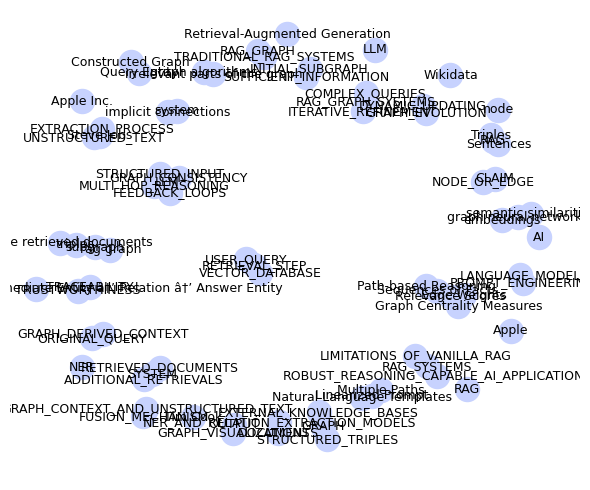

Saved visualization to C:\dev\RAGdoll\examples\demo_state\graph_demo\graph_demo.png


In [10]:
# Run ingestion
sources = [str(SAMPLE_TXT)]
result = await ingest_documents(sources, options=options)
stats = result.get("stats", {})
graph = result.get("graph")

# Print results
print(f"✅ Ingestion complete!")
print(f"Documents processed: {stats.get('documents_processed')}")
print(f"Chunks created: {stats.get('chunks_created')}")
print(f"Entities extracted: {stats.get('entities_extracted')}")
print(f"Relationships extracted: {stats.get('relationships_extracted')}")
print(f"Vector entries added: {stats.get('vector_entries_added')}")
print(f"Graph entries added: {stats.get('graph_entries_added')}")

if stats.get("errors"):
    print(f"⚠️ Warnings/Errors:")
    for error in stats["errors"]:
        print(f"  - {error}")

# Visualize the graph
try:
    import matplotlib.pyplot as plt
    import networkx as nx

    if graph and hasattr(graph, 'nodes') and graph.nodes:
        viz_graph = nx.Graph()
        for node in graph.nodes:
            viz_graph.add_node(node.id, label=node.name, type=node.type)
        for edge in graph.edges:
            viz_graph.add_edge(edge.source, edge.target, relationship=edge.type)

        if viz_graph.number_of_nodes() > 0:
            plt.figure(figsize=(6, 5))
            positions = nx.spring_layout(viz_graph, seed=42)
            labels = {node_id: viz_graph.nodes[node_id].get('label', node_id) for node_id in viz_graph.nodes}
            nx.draw_networkx_nodes(viz_graph, positions, node_color='#c7d2fe', linewidths=1)
            nx.draw_networkx_edges(viz_graph, positions, edge_color='#4c51bf')
            nx.draw_networkx_labels(viz_graph, positions, labels=labels, font_size=9)
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(graph_image_path, dpi=160)
            plt.show()
            print(f'Saved visualization to {graph_image_path}')
        else:
            print('Graph has no nodes to visualize.')
    else:
        print('No graph available to visualize.')
except Exception as exc:
    print(f'Skipped visualization: {exc}')


## 6. Query vector + graph context
`GraphPersistenceService` reloads the extracted graph into a LangChain retriever so we can compare vector hits against graph nodes for the same question. This mirrors the hybrid pattern we feed into the orchestration demo later on.

In [11]:
graph_persistence = GraphPersistenceService(
    output_format='custom_graph_object',
    retriever_backend='simple',
    retriever_config={'top_k': 3, 'include_edges': True},
)

_ = graph_persistence.save(graph)
graph_retriever = graph_persistence.create_retriever()

hybrid_question = 'Which people or organizations are mentioned in the txt sample?'
vector_hits = demo_vector_store.similarity_search(hybrid_question, k=2)
graph_hits = graph_retriever.get_relevant_documents(hybrid_question)

print(f"Vector store returned {len(vector_hits)} document(s)")
for idx, doc in enumerate(vector_hits, start=1):
    snippet = doc.page_content[:200].replace('\n', ' ')
    print(f"- Vector hit {idx} (source={doc.metadata.get('source')}): {snippet}")

print(f"Graph retriever returned {len(graph_hits)} node(s)")
for doc in graph_hits:
    print(
        f"- Node {doc.metadata.get('node_id')} ({doc.metadata.get('node_type')}): {doc.page_content}"
    )

Vector store returned 2 document(s)
- Vector hit 1 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt): the system parses these documents to extract entities (such as people, organizations, or concepts) and relationships (like "works at" or "caused by") using named entity recognition (NER) and relation 
- Vector hit 2 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt): Finally, the output includes not just the generated text but optional graph visualizations or citations mapping back to original documents. This traceability improves trustworthiness, especially in do
Graph retriever returned 0 node(s)


## 7. Wire up an LLM caller
`get_llm_caller` now instantiates the OpenAI chat model defined in `ragdoll/config/default_config.yaml` (defaults to `gpt-4o-mini`). Make sure `OPENAI_API_KEY` is available before running the next cell.


In [12]:
import os

if not os.getenv('OPENAI_API_KEY'):
    raise EnvironmentError('Set OPENAI_API_KEY before calling the real OpenAI demo cell.')

openai_llm_caller = get_llm_caller(app_config=app_config)

sample_text = chunks[0].page_content if chunks else documents[0].page_content
prompt = (
    'Summarize the following text sample in one sentence. Mention what the document is about and highlight any key people, organizations, or actions.'
    f"{sample_text[:2048]}"
)
print('Sample excerpt:', sample_text[:360].replace('\n', ' '))
llm_reply = call_llm_sync(openai_llm_caller, prompt)
print('OpenAI response:', llm_reply)


Sample excerpt: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved information into a dynamic knowledge graph rather than treating it as flat text chunks. At its core, it
OpenAI response: The document discusses Rag graph, an advanced Retrieval-Augmented Generation system that organizes retrieved information into a dynamic knowledge graph, improving upon traditional methods that use flat text chunks.


## 8. Run the ingestion pipeline (async)
`IngestionPipeline` stitches together the loader, chunker, embeddings, vector store, and optional graph/entity stages. We disable entity extraction to keep the run lightweight and await the coroutine directly inside the notebook.


In [13]:
pipeline_store_dir = reset_subdir('chroma_pipeline_demo')
pipeline_vector_config = VectorStoreConfig(
    enabled=True,
    store_type='chroma',
    params={
        'collection_name': 'ragdoll_pipeline_demo',
        'persist_directory': str(pipeline_store_dir),
    },
)
pipeline_vector_store = vector_store_from_config(
    pipeline_vector_config,
    embedding=embeddings,
)

pipeline = IngestionPipeline(
    app_config=app_config,
    content_extraction_service=DocumentLoaderService(
        app_config=app_config,
        use_cache=False,
        collect_metrics=False,
    ),
    embedding_model=embeddings,
    vector_store=pipeline_vector_store,
    options=IngestionOptions(
        batch_size=2,
        extract_entities=False,
        skip_graph_store=True,
        chunking_options={'chunk_size': 300, 'chunk_overlap': 60, 'splitter_type': 'recursive'},
    ),
)

pipeline_stats = await pipeline.ingest([str(SAMPLE_TXT)])
pipeline_stats


{'documents_processed': 1,
 'chunks_created': 17,
 'entities_extracted': 0,
 'relationships_extracted': 0,
 'vector_entries_added': 17,
 'graph_entries_added': 0,
 'errors': [],
 'graph_retriever_available': False}

## 9. Use the Ragdoll orchestrator
Finally, plug the embeddings/vector store plus the real OpenAI LLM caller into `ragdoll.Ragdoll` so you can see how ingestion and `query` behave from the package's public API.


In [14]:
import os

if not os.getenv('OPENAI_API_KEY'):
    raise EnvironmentError('Set OPENAI_API_KEY before running the orchestrator demo.')

rag_store_dir = reset_subdir('chroma_ragdoll_demo')
rag_vector_config = VectorStoreConfig(
    enabled=True,
    store_type='chroma',
    params={
        'collection_name': 'ragdoll_orchestrator_demo',
        'persist_directory': str(rag_store_dir),
    },
)
rag_vector_store = vector_store_from_config(
    rag_vector_config,
    embedding=embeddings,
)

rag_llm_caller = get_llm_caller(app_config=app_config)

rag = Ragdoll(
    app_config=app_config,
    ingestion_service=DocumentLoaderService(
        app_config=app_config,
        use_cache=False,
        collect_metrics=False,
    ),
    embedding_model=embeddings,
    vector_store=rag_vector_store,
    llm_caller=rag_llm_caller,
)

question = 'What does the sample document discuss?'
ingested = rag.ingest_data([str(SAMPLE_TXT)])
print(f"Ragdoll indexed {len(ingested)} LangChain document(s).")
rag_response = rag.query(question)
print('LLM answer:', rag_response['answer'])
for idx, doc in enumerate(rag_response['documents'], start=1):
    snippet = doc.page_content[:140].replace('\n', ' ')
    print(f"Doc {idx} (source={doc.metadata.get('source')}): {snippet}")

graph_docs = (
    graph_retriever.get_relevant_documents(question)
    if 'graph_retriever' in globals()
    else []
)
if graph_docs:
    print('Graph retriever context:')
    for doc in graph_docs:
        print(f"- {doc.metadata.get('node_type')} {doc.metadata.get('node_id')}: {doc.page_content}")

    vector_context = ''.join(f"Doc {idx}: {doc.page_content[:200]}" for idx, doc in enumerate(rag_response['documents'], start=1)
    ) or 'No vector hits available.'
    graph_context = ''.join(
        f"Node {doc.metadata.get('node_id')}: {doc.page_content} (neighbors={doc.metadata.get('connected_to')})"
        for doc in graph_docs
    )
    hybrid_prompt = ('You answer using both vector chunks and graph nodes.'
        f"Vector context: {vector_context}"
        f"Graph context: {graph_context}"
        f"Question: {question}"
        'Answer:'
    )
    hybrid_answer = call_llm_sync(rag_llm_caller, hybrid_prompt)
    print('Hybrid graph + vector answer:', hybrid_answer)
elif 'graph_retriever' not in globals():
    print('Graph retriever not initialized yet; run Section 6 to build it before rerunning this cell.')
else:
    print('Graph retriever initialized but returned no hits for this question; try a different query or ensure the earlier graph run covered the relevant entities.')


Ragdoll indexed 1 LangChain document(s).
LLM answer: The sample document discusses the concept of rag graph, which enhances traditional Retrieval-Augmented Generation (RAG) systems by using a dynamic knowledge graph to structure retrieved information. It outlines the process of extracting entities and relationships from documents, constructing a relevant subgraph, and using graph algorithms for refinement. The document also explains how this structured context is integrated with language models to improve response accuracy and explainability, as well as the iterative refinement process for handling complex queries. Additionally, it highlights the importance of traceability and trustworthiness in generated outputs.
Doc 1 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt): Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retr
Graph retriever initialized but returned no hits for this question; try a d

---
Feel free to duplicate this notebook and swap inputs (PDFs, DOCX, loaders, vector stores, etc.) to explore other combinations covered throughout `docs/`.
